<a href="https://colab.research.google.com/github/panicoro/FS-process-image/blob/master/Entrega_Pr%C3%A1ctica_3_Pablo_Rosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 3: Segmentación de Imágenes**

En esta práctica, implementaremos y entrenaremos un modelo U-Net para la tarea de segmentación de imágenes de radiografías de tórax, enfocándonos en segmentación de las estructuras pulmonares.

El modelo U-Net es ampliamente utilizado en la segmentación de imágenes médicas debido a su capacidad para capturar tanto características de bajo nivel como de alto nivel. Para obtener más información sobre el modelo U-Net, consultar el paper original disponible en: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).

Para comenzar, importamos todas las bibliotecas que necesitaremos:

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset, DataLoader
from PIL import Image

## **Dataset JSRT**

Utilizaremos el dataset [JSRT](http://db.jsrt.or.jp/eng.php), que contiene imágenes de radiografías de tórax y sus correspondientes máscaras de segmentación de los pulmones.



En primer lugar, **descargá la versión reducida del dataset**, que contiene imágenes en resolución 256x256, desde [este enlace](https://drive.google.com/file/d/1-faPhIl7tWxC0AgWx4zmnm1iP5J2YBwu/view?usp=sharing).

Una vez completada la descarga, **descomprimí el archivo .zip y ubicá la carpeta "Segmentation01" en el directorio principal de tu Google Drive**. Así, la estructura de archivos debería quedar de la siguiente manera:

```
Mi Unidad/
    Segmentation01/
        train/
        test/
        list_train.txt
        list_test.txt
```

Antes de acceder a los datos, es necesario **montar tu Google Drive en el entorno de Google Colab**.

Para ello, ejecutá la celda de código que sigue y seguí las instrucciones:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Una vez montado el Drive, podés acceder a la carpeta "Segmentation01" usando la siguiente ruta:

In [ ]:
root_dir = "/content/drive/My Drive/Segmentation01/"

## **Lectura, partición y visualización de datos**


En esta parte, utilizaremos la función `load_image_mask_paths` para leer y cargar las rutas de las imágenes y máscaras correspondientes desde los archivos `list_train.txt` y `list_test.txt`. Estos archivos contienen la **lista de imágenes y máscaras que se utilizarán para entrenamiento y prueba**, respectivamente:

In [ ]:
def load_image_mask_paths(file_path):
    """
    Lee un archivo y devuelve una lista de tuplas donde cada tupla
    contiene la ruta de una imagen y su correspondiente máscara.

    Args:
        file_path (str): Ruta al archivo que contiene las rutas de las
        imágenes y máscaras.

    Returns:
        list of tuples: Lista de tuplas (image_path, mask_path).
    """
    image_mask_paths = []
    with open(file_path, "r") as file:
        for line in file:
            # Limpia la línea eliminando espacios y reemplaza las barras
            # invertidas con barras normales
            cleaned_line = line.strip().replace("\\", "/")

            # Elimina el prefijo "./" si está presente al inicio de la línea
            if cleaned_line.startswith("./"):
                cleaned_line = cleaned_line[2:]

            # Divide la línea en ruta de imagen y ruta de máscara,
            # y las agrega a la lista
            image_path, mask_path = cleaned_line.split(",")
            image_mask_paths.append((image_path, mask_path))

    return image_mask_paths


# Rutas de los archivos que contienen las listas de imágenes y máscaras para
# entrenamiento y prueba
train_files = os.path.join(root_dir, "list_train.txt")
test_files = os.path.join(root_dir, "list_test.txt")

# Leemos las rutas de las imágenes y máscaras para entrenamiento y prueba
train_image_mask_paths = load_image_mask_paths(train_files)
test_image_mask_paths = load_image_mask_paths(test_files)

A continuación, dividimos el conjunto de entrenamiento en dos subconjuntos, **uno para entrenamiento y otro para validación**:


In [ ]:
# Definimos el tamaño del conjunto de validación
val_samples = len(test_image_mask_paths)

# Tamaño del conjunto de entrenamiento
train_samples = len(train_image_mask_paths)

# Generamos índices aleatorios para el conjunto de validación
val_indices = random.sample(range(train_samples), val_samples)

# Separamos los índices en conjuntos de entrenamiento y validación
val_image_mask_paths = [train_image_mask_paths[i] for i in val_indices]
train_image_mask_paths = [train_image_mask_paths[i] for i
                          in range(train_samples) if i not in val_indices]


# Imprimimos la cantidad de ejemplos de entrenamiento, validación y prueba
print(f"Cantidad de ejemplos de entrenamiento: {len(train_image_mask_paths)}")
print(f"Cantidad de ejemplos de validación: {len(val_image_mask_paths)}")
print(f"Cantidad de ejemplos de prueba: {len(test_image_mask_paths)}")

Cantidad de ejemplos de entrenamiento: 40
Cantidad de ejemplos de validación: 10
Cantidad de ejemplos de prueba: 10


Por último, visualizamos algunos ejemplos del conjunto de entrenamiento:

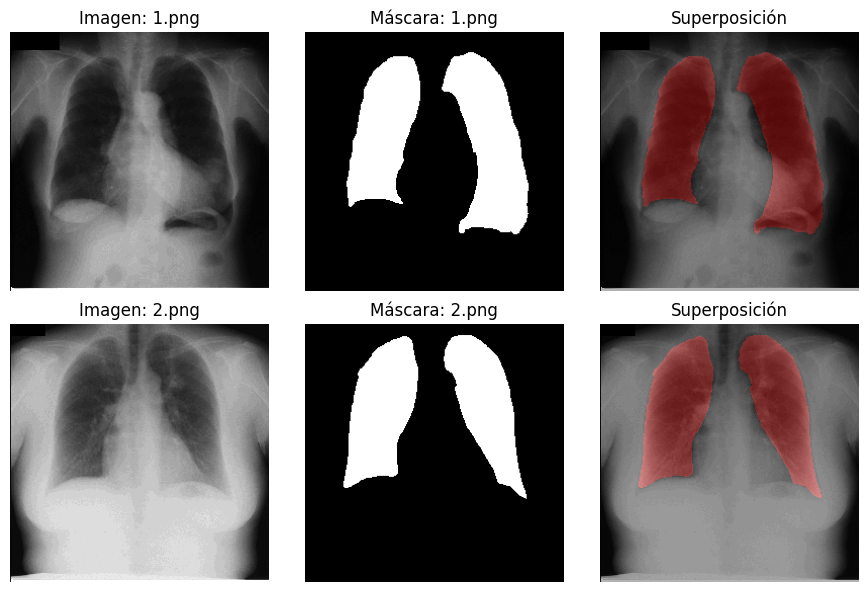

In [ ]:
# Cantidad de ejemplos a visualizar
num_samples_to_display = 2
num_samples_to_display = min(num_samples_to_display,
                             len(train_image_mask_paths))

plt.figure(figsize=(9, num_samples_to_display * 3))

for i, (image_path, mask_path) in enumerate(
    train_image_mask_paths[:num_samples_to_display]):
    # Cargamos la imagen y la máscara
    image = Image.open(os.path.join(root_dir, image_path)).convert("RGB")
    mask = Image.open(os.path.join(root_dir, mask_path)).convert("L")

    # Convertimos la máscara a un array de numpy y normalizamos
    mask_array = np.array(mask)
    mask_color = np.zeros((*mask_array.shape, 3), dtype=np.uint8)
    mask_color[mask_array > 0] = [255, 0, 0]  # Color rojo para la máscara

    # Convertimos a imágenes PIL
    mask_color_image = Image.fromarray(mask_color)

    # Superponemos la máscara sobre la imagen
    superimposed_image = Image.blend(image, mask_color_image, alpha=0.3)

    # Muestra la imagen original
    plt.subplot(num_samples_to_display, 3, i * 3 + 1)
    plt.imshow(image)
    plt.title(f"Imagen: {os.path.basename(image_path)}")
    plt.axis('off')

    # Muestra la máscara
    plt.subplot(num_samples_to_display, 3, i * 3 + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Máscara: {os.path.basename(mask_path)}")
    plt.axis('off')

    # Muestra la superposición de la máscara sobre la imagen
    plt.subplot(num_samples_to_display, 3, i * 3 + 3)
    plt.imshow(superimposed_image)
    plt.title(f"Superposición")
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Definición de un dataset personalizado en PyTorch**

Lo que haremos a continuación, será **crear una clase personalizada en PyTorch para manejar y procesar los datos del conjunto JSRT**. Esta clase nos permitirá cargar las imágenes y máscaras, aplicar transformaciones para aumentación de datos, y preparar los datos para el entrenamiento del modelo.

PyTorch proporciona la clase `torch.utils.data.Dataset`, que nos permite crear datasets a medida. Nuestra clase heredará de esta y nos permitirá controlar cómo se cargan los datos y cómo se aplican las transformaciones.

Para obtener más información sobre cómo crear y utilizar datasets en PyTorch, podés consultar la [documentación oficial](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) y algunos tutoriales útiles como [éste](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).



In [ ]:
class JSRTDataset(Dataset):
    """
    Dataset personalizado para el conjunto de datos JSRT.

    Args:
        root_dir (str): Directorio raíz donde se encuentran las imágenes
        y máscaras.
        image_mask_paths (list of tuples): Lista de tuplas (image_path,
        mask_path) con las rutas a las imágenes y máscaras.
        is_train (bool): Indica si el dataset se utiliza para entrenamiento.
        Si es True, se aplican aumentaciones. Si es False, no se aplican.
    """
    def __init__(self, root_dir, image_mask_paths, is_train=True):
        self.root_dir = root_dir
        self.image_mask_paths = image_mask_paths
        self.is_train = is_train

    def __len__(self):
        """
        Devuelve el número total de ejemplos en el dataset.

        Returns:
            int: Número de ejemplos en el dataset.
        """
        return len(self.image_mask_paths)

    def transform(self, image, mask):
        """
        Aplica las transformaciones a un ejemplo del dataset.

        Args:
            image (PIL.Image): Imagen a transformar.
            mask (PIL.Image): Máscara a transformar.

        Returns:
            tuple: Imagen y máscara transformadas.
        """
        # Aplicamos reflejo horizontal
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Aplicamos rotación
        if random.random() > 0.5:
            # Ángulo de rotación aleatorio entre -5 y 5 grados
            angle = int(random.uniform(-5, 5))
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        # Convertimos a tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

    def __getitem__(self, idx):
        """
        Obtiene una muestra del dataset.

        Args:
            idx (int): Índice de la muestra a obtener.

        Returns:
            tuple: Imagen y máscara en el índice proporcionado,
            después de aplicar las transformaciones (si las hay).
        """
        image_path, mask_path = self.image_mask_paths[idx]

        # Cargamos la imagen y la máscara
        image = Image.open(os.path.join(self.root_dir,
                                        image_path)).convert("L")
        mask = Image.open(os.path.join(self.root_dir,
                                       mask_path)).convert("L")

        # Aplicamos las transformaciones si el dataset está en
        # modo entrenamiento
        if self.is_train:
            image, mask = self.transform(image, mask)

        # Nos aseguramos que la imagen y la máscara sean tensores
        if not isinstance(image, torch.Tensor):
            image = TF.to_tensor(image)
        if not isinstance(mask, torch.Tensor):
            mask = TF.to_tensor(mask)

        return image, mask

## **Modelo U-Net para segmentación**

A continuación, procederemos a definir el modelo U-Net que utilizaremos para segmentar imágenes de radiografías de tórax.

Puntos clave a tener en cuenta:

- **Convoluciones:** para simplificar la implementación, utilizar convoluciones que mantengan el tamaño de la entrada. Esto se puede lograr mediante convoluciones 2D con un kernel de 3x3, padding de 1 y stride de 1.

- **Estructura del Encoder:** el encoder de la U-Net deberá tener 4 bloques, cada uno compuesto por dos capas de convolución (usar la función `double_conv`) seguidas de una operación de max pooling (2x2) para reducir las dimensiones espaciales.

- **Estructura del Bottleneck:** en el cuello de botella (bottleneck), aplicar dos capas de convolución adicionales (usar la función `double_conv`) sin max pooling, para capturar características de mayor profundidad sin reducir más las dimensiones espaciales.

- **Estructura del Decoder:** el decoder deberá contener 4 bloques, cada uno comenzando con una convolución transpuesta para aumentar la dimensión espacial, seguida de dos capas de convolución (usar la función `double_conv`).

- **Skip connections:** para implementar las skip connections, utilizar el método `torch.cat` para concatenar los feature maps correspondientes del encoder y el decoder en cada bloque.

- **Función de activación:** utilizaremos la función de activación ReLU (`torch.nn.ReLU()`) en todas las capas convolucionales.

- **Cantidad de feature maps:**
  - **Bloque 1:** 32 feature maps
  - **Bloque 2:** 64 feature maps
  - **Bloque 3:** 128 feature maps
  - **Bloque 4:** 256 feature maps

- **Capa de salida:** en la última capa del decoder, aplicar una convolución con un kernel de 1x1 para transformar los últimos 32 feature maps en un solo feature map, correspondiente al mapa de segmentación final.

In [ ]:
def double_conv(in_channels, features):
    """
    Realiza dos capas de convolución seguidas de activaciones ReLU.

    Args:
        in_channels (int): Número de canales de entrada.
        features (int): Número de canales de salida.

    Returns:
        nn.Sequential: Secuencia de dos capas convolucionales y activaciones ReLU.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, features, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    """
    Implementación simplificada de la arquitectura U-Net para segmentación
    de imágenes.

    Args:
        in_channels (int): Número de canales de entrada. Por defecto es 3.
        out_channels (int): Número de canales de salida. Por defecto es 1.
        init_features (int): Número inicial de características.
        Por defecto es 32.
    """
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Encoder: cuatro bloques con capas convolucionales + pooling
        self.encoder1 = double_conv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = double_conv(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = double_conv(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = double_conv(128, 256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck: parte central de la U-Net que conecta el encoder
        # con el decoder
        self.bottleneck = double_conv(256, 512)

        # Decoder: cuatro bloques con capas de
        # convolución transpuesta + convolución
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = double_conv(256 * 2, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = double_conv(128 * 2, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = double_conv(64 * 2, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = double_conv(32 * 2, 32)

        # Capa final de convolución para reducir los canales a
        # la cantidad de salida deseada
        self.conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante por la U-Net.

        Args:
            x (torch.Tensor): Tensor de entrada con dimensiones (batch_size,
            in_channels, H, W).

        Returns:
            torch.Tensor: Tensor de salida con dimensiones (batch_size,
            out_channels, H, W).
        """
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder con concatenación y skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Concatenación con la salida del encoder (skip connection)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)  # Concatenación con la salida del encoder (skip connection)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)  # Concatenación con la salida del encoder (skip connection)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)  # Concatenación con la salida del encoder (skip connection)
        dec1 = self.decoder1(dec1)

        # Capa de salida
        y = self.conv(dec1)

        return y

## **Implementación del entrenamiento**

En esta etapa, implementaremos el proceso de entrenamiento para el modelo de segmentación U-Net.

Detalles del entrenamiento:

- **Optimizador:** utilizaremos el optimizador **Adam** (podés consultar el paper [acá](https://arxiv.org/abs/1412.6980)), una variante del algoritmo de descenso de gradiente estocástico (SGD). Adam ajusta dinámicamente la tasa de aprendizaje durante el entrenamiento.

- **Función de pérdida:** la función de pérdida será **entropía cruzada binaria** (`nn.BCEWithLogitsLoss`). Esta función es ideal para tareas de segmentación binaria ya que combina la activación sigmoide y la entropía cruzada en una sola operación, simplificando así el cálculo.

- **Tasa de aprendizaje:** la tasa de aprendizaje inicial será de **0.001** (1e-3). Este valor se puede ajustar durante el entrenamiento si se observa que el modelo converge demasiado rápido o demasiado lento.

- **Regularización:** aplicaremos un **weight decay** de **0.00001** (1e-5). Esta técnica ayuda a prevenir el sobreajuste al añadir una penalización al tamaño de los pesos del modelo, promoviendo la generalización.

- **Tamaño del batch:** utilizaremos un tamaño de batch de **4 ejemplos**. Este tamaño puede ser modificado en función de la capacidad de la GPU y de los recursos computacionales disponibles.

- **Número de épocas:** el modelo se entrenará durante **50 épocas**. Si se dispone de una GPU en el entorno de Colab, este número puede incrementarse a **200 épocas** para mejorar la convergencia y el rendimiento del modelo.

---

Primero, definimos el modelo, la función de pérdida y el optimizador:

In [ ]:
# Configuramos del dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creamos el modelo y los mandamos al dispositivo
model = UNet(in_channels=1, out_channels=1)
model.to(device)

# Función de pérdida y optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

A continuación, configuraremos los datasets para entrenamiento, validación y prueba, así como los dataloaders correspondientes para manejar los batches de datos.

Recordemos que:
- El conjunto de datos de **entrenamiento** se utiliza para **entrenar el modelo**.
- El conjunto de datos de **validación** se utiliza para **validar el rendimiento del modelo durante el entrenamiento**.
- El conjunto de datos de **prueba**  se utiliza para **evaluar el rendimiento final del modelo después del entrenamiento**.


Los dataloaders para el conjunto de entrenamiento manejarán los batches de datos con un tamaño especificado (en nuestro caso, 4 ejemplos por batch). **Para los conjuntos validación y prueba, fijaremos el tamaño de los batches a 1**. Esto nos va a permitir evaluar las imágenes individualmente.


In [ ]:
# Creamos las instancias de los datasets para entrenamiento, validación
# y prueba
train_dataset = JSRTDataset(root_dir, train_image_mask_paths, is_train=True)
val_dataset = JSRTDataset(root_dir, val_image_mask_paths, is_train=False)
test_dataset = JSRTDataset(root_dir, test_image_mask_paths, is_train=False)

# Creamos los dataLoaders para manejar los batches de entrenamiento,
# validación y prueba
batch_size = 4
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

A continuación, **implementamos el proceso de entrenamiento del modelo**:

In [ ]:
# Lista para guardar los valores de pérdida durante el entrenamiento
train_loss = []
val_loss = []

# Épocas de entrenamiento
num_epochs = 200

# Inicializamos la pérdida de validación para monitoreo
best_val_loss = float("inf")

# Bucle de entrenamiento
for epoch in range(num_epochs):

    # Entrenamiento
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_loss.append(epoch_train_loss)

    # Validación
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss.append(epoch_val_loss)

    print(f"Época {epoch + 1}/{num_epochs}, Pérdida de entrenamiento:
    {epoch_train_loss:.4f}, Pérdida de validación: {epoch_val_loss:.4f}")

    # Guardamos el modelo si la pérdida de validación mejora
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "model_best.pth")

Época 1/200, Pérdida de entrenamiento: 0.6179, Pérdida de validación: 0.5232
Época 2/200, Pérdida de entrenamiento: 0.5315, Pérdida de validación: 0.4691
Época 3/200, Pérdida de entrenamiento: 0.4605, Pérdida de validación: 0.4304
Época 4/200, Pérdida de entrenamiento: 0.4459, Pérdida de validación: 0.3991
Época 5/200, Pérdida de entrenamiento: 0.4211, Pérdida de validación: 0.3960
Época 6/200, Pérdida de entrenamiento: 0.3967, Pérdida de validación: 0.3774
Época 7/200, Pérdida de entrenamiento: 0.3849, Pérdida de validación: 0.3593
Época 8/200, Pérdida de entrenamiento: 0.3734, Pérdida de validación: 0.3513
Época 9/200, Pérdida de entrenamiento: 0.3478, Pérdida de validación: 0.3692
Época 10/200, Pérdida de entrenamiento: 0.3135, Pérdida de validación: 0.2884
Época 11/200, Pérdida de entrenamiento: 0.2860, Pérdida de validación: 0.2584
Época 12/200, Pérdida de entrenamiento: 0.2758, Pérdida de validación: 0.3025
Época 13/200, Pérdida de entrenamiento: 0.2724, Pérdida de validación: 0.

Visualizamos las curvas de entrenamiento y validación:

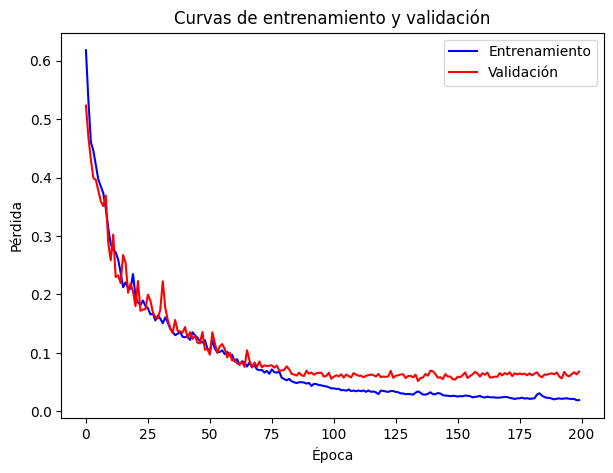

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(train_loss, label="Entrenamiento", color="blue")
plt.plot(val_loss, label="Validación", color="red")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Curvas de entrenamiento y validación")
plt.legend()
plt.grid(False)
plt.show()

Puede verse como a partir de la época 60-65 empiezan a mostrar sobreajuste el modelo.

## **Evaluación del modelo en el conjunto de prueba**

Habiendo entrenado el modelo, **vamos a evaluar su desempeño utilizando el conjunto de prueba**.

Para evaluar la calidad de las segmentaciones que el modelo predice, utilizaremos dos métricas:

- **Accuracy (Exactitud):** medimos la exactitud del modelo en la clasificación de cada píxel, calculando la proporción de píxeles correctamente clasificados en relación con el total de píxeles.

- **Dice Coefficient (Coeficiente de Dice):** calculamos el coeficiente de Dice, midiendo la superposición entre la máscara predicha y la máscara verdadera, proporcionando una medida de similitud entre ambas.


In [ ]:
def calculate_accuracy(preds, labels):
    """
    Calcula la exactitud (accuracy) para un batch de predicciones y etiquetas.

    Args:
        preds (torch.Tensor): Predicciones del modelo (tensor de tamaño [1, 1, H, W]).
        labels (torch.Tensor): Etiquetas verdaderas (tensor de tamaño [1, 1, H, W]).

    Returns:
        float: Exactitud del batch.
    """
    # Calculamos la accuracy (total de píxeles correctos dividido por el
    # total de píxeles)
    correct = (preds == labels).float()
    accuracy = correct.sum() / correct.numel()

    return accuracy.item()

def calculate_dice(preds, labels):
    """
    Calcula el coeficiente Dice para un batch de predicciones y etiquetas.

    Args:
        preds (torch.Tensor): Predicciones del modelo (tensor de tamaño [1, 1, H, W]).
        labels (torch.Tensor): Etiquetas verdaderas (tensor de tamaño [1, 1, H, W]).

    Returns:
        float: Coeficiente Dice del batch.
    """
    # Calculamos el Dice
    intersection = (preds * labels).sum()
    union = preds.sum() + labels.sum()
    dice = 2. * intersection / union

    return dice.item()

Cargamos el modelo entrenado y lo evaluamos el modelo en el conjunto de prueba y calculamos las métricas:

In [ ]:
# Cargamos el modelo entrenado
model.load_state_dict(torch.load("model_best.pth", weights_only=True))
model.to(device)

# Evaluación
model.eval()
total_accuracy = 0.0
total_dice = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        accuracy = calculate_accuracy(preds, labels)
        total_accuracy += accuracy

        dice = calculate_dice(preds, labels)
        total_dice += dice

average_accuracy = total_accuracy / len(test_loader)
average_dice = total_dice / len(test_loader)

print("Resultados U-Net:\n")
print(f"Accuracy: {average_accuracy:.4f}")
print(f"Dice: {average_dice:.4f}")

Resultados U-Net:

Accuracy: 0.9664
Dice: 0.9459


Los resultados de tu modelo U-Net muestran un accuracy de 0.9664 y un Dice coefficient de 0.9459, lo cual indica un excelente desempeño en la tarea de segmentación. Un Dice coefficient superior a 0.94 sugiere que las áreas segmentadas por el modelo coinciden muy bien con las regiones verdaderas del ground truth, lo que es clave en tareas de segmentación médica.

Para finalizar, visualicemos algunas predicciones del modelo y comparemos con las máscaras verdaderas:

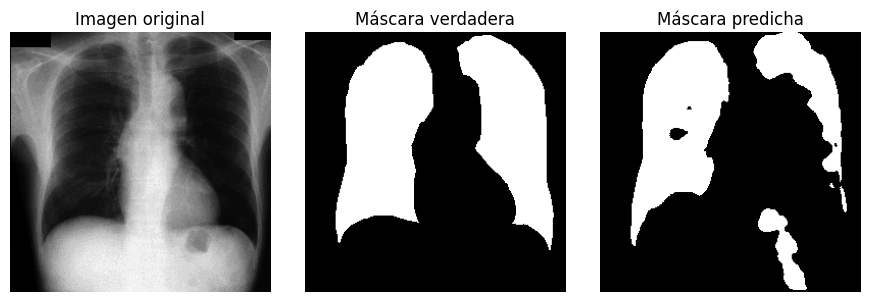

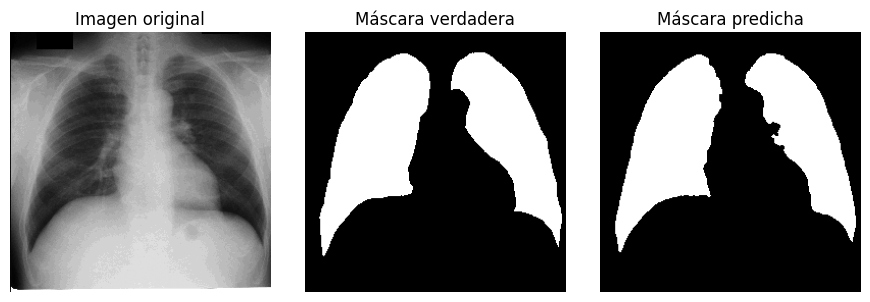

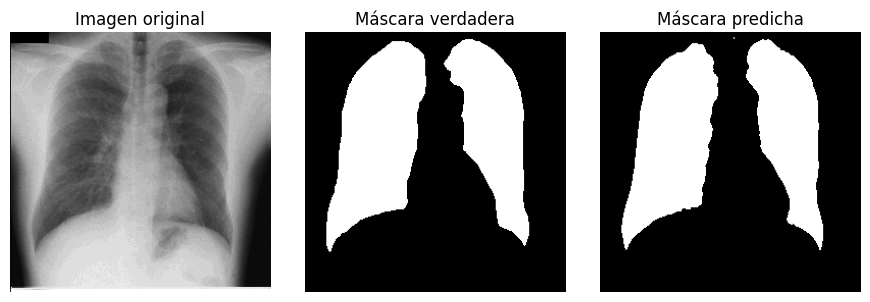

In [ ]:
# Cantidad de ejemplo a visualizar
num_samples_to_display = 3
num_samples_to_display = min(num_samples_to_display, len(test_loader.dataset))

model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):

        if i >= num_samples_to_display:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        image = inputs[0].cpu().squeeze().numpy()
        true_mask = labels[0].cpu().squeeze().numpy()
        pred_mask = outputs[0].cpu().squeeze().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        fig, axs = plt.subplots(1, 3, figsize=(9, 3))
        axs[0].imshow(image, cmap="gray")
        axs[0].set_title("Imagen original")
        axs[0].axis('off')

        axs[1].imshow(true_mask, cmap="gray")
        axs[1].set_title("Máscara verdadera")
        axs[1].axis('off')

        axs[2].imshow(pred_mask, cmap="gray")
        axs[2].set_title("Máscara predicha")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

Se entrenó un modelo U-Net para la tarea de segmentación de imágenes de radiografías de tórax, para buscar segmentar las estructuras pulmonares. En un primer momento se entrenó el modelo con 50 épocas, pero los resultados de accuracy y dice no fueron muy buenos, por lo que se aumento el número a 200 como estaba sugerido.

Al ver las predicciones con las máscaras verdaderas se observa que las regiones pulmonares aparecen bien posicionadas, pero sus bordes no son exactamente iguales. En el primer ejemplo, se observa que el pulmón izquierdo no está bien definido y aparece una región inferior separada de él.  

## **Entregable**

Completar el código y analizar los resultados obtenidos.